In [1]:
# Numerical/Stats pack
import pandas as pd
import numpy as np
from collections import Counter
import math
import numpy.linalg as nl
from cvxopt import matrix, solvers
import scipy.stats as ss

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from qiskit.visualization import plot_histogram

import warnings
warnings.filterwarnings('ignore')

In [2]:
def qubit_matrix(p0m0,p1m1):
    """
    Parameters
    ----------
    p0m0 : ndarray(dtype=np.float64, dim=num_qubits)
        Pr(0|0) for all qubits
    p1m1 : ndarray(dtype=np.float64, dim=num_qubits)
        Pr(1|1) for all qubits

    Returns
    -------
    mats: np.array(dim=num_qubits*2*2)
        mats[i] is 2-by-2 measurement error transition matrix for ith qubit
    """
    num_qubits = p0m0.shape[0]
    mats = np.zeros((num_qubits,2,2), dtype=np.float64)
    for i in range(num_qubits):
        mats[i] = np.array([[p0m0[i], 1-p1m1[i]],[1-p0m0[i], p1m1[i]]])
        
    return mats

def dictToVec(nQubits, counts):
    """ Transfer counts to probabilities

    Args:
      nQUbits: int
        number of qubits
      counts: dict
        an dictionary in the form {basis string: frequency}. E.g.
        {"01": 100
         "11": 100}
        dict key follow little-endian convention

    Returns: numpy array
      an probability vector (array). E.g.
      [0, 0.5, 0, 0.5] is the result from example above.
    """
    vec = np.zeros(2**nQubits)
    form = "{0:0" + str(nQubits) + "b}"
    for i in range(2**nQubits):
        key = form.format(i) # consider key = format(i,'0{}b'.format(nQubits))
                             # and delete variable form
        if key in counts.keys():
            vec[i] = int(counts[key])
        else:
            vec[i] = 0
    return vec

In [3]:
# Cite https://www.geeksforgeeks.org/check-whether-two-numbers-differ-one-bit-position/
  
# function to check if x is power of 2 
def isPowerOfTwo( x ): 
  
    # First x in the below expression is 
    # for the case when x is 0 
    return x and (not(x & (x - 1))) 
  
# function to check whether the two numbers 
# differ at one bit position only 
def differAtOneBitPos( a , b ): 
    return isPowerOfTwo(a ^ b) 
 
# Function to find the position of 
# rightmost set bit in 'n'
def getRightMostSetBit(n):
    if (n == 0):
        return 0
 
    return math.log2(n & -n)
 
# Cite https://www.geeksforgeeks.org/position-rightmost-different-bit/
# Function to find the position of 
# rightmost different bit in the 
# binary representations of 'm' and 'n'
def posOfRightMostDiffBit(m, n):
 
    # position of rightmost different
    # bit
    return int(getRightMostSetBit(m ^ n))

In [4]:
def remaining_bits(s, interested_qubits, num_qubits):
    # Remove bits from interested_qubits. 
    # E.g., interested_qubits = [0,3] and num_qubits = 5, s = '10101',
    # then function returns '011'
    res = []
    for i in range(num_qubits):
        if i not in interested_qubits:
            res.append(s[i])
    return ''.join(res)

In [5]:
import re
def all0_all1_counts(interested_qubits, num_points, num_qubits, file_address):
    # Read data from 00000 and 11111 files. num_points = number of probabilities
    
    p0m0 = np.zeros((len(interested_qubits), num_points), dtype=np.float64)

    string_data = np.genfromtxt(file_address + 'Basis'+('0'*num_qubits)+'.csv', delimiter=',',dtype=np.str)
    data_groups = np.split(string_data, num_points) # Divided data into num_points of groups
    for i in range(num_points):
        # Initialize
        group = data_groups[i]
        p0m1_count = np.zeros(len(interested_qubits), dtype=np.int) # Record number of appearease of prepare 0 measure 1
        p0m0_total = np.zeros(len(interested_qubits), dtype=np.int) # Record number of data entries does not have correlated errors
        # Select the right bits
        for bits in group:
            if bits.count("1") == 0: # When all qubits are noise-free
                p0m0_total = p0m0_total + 1  
            if remaining_bits(bits, interested_qubits, num_qubits).count("1") == 0: # When only interested qubits have errors
                poss = np.array([])
                for m in re.finditer('1', bits): # Find all erronous positions
                    poss = np.append(poss, m.start())
                for pos in poss:
                    p0m1_count[interested_qubits.index(pos)] += 1
                    p0m0_total[interested_qubits.index(pos)] += 1

#     Record probability of prepare 0 measure 0
        p0m0[:,i] = (p0m0_total-p0m1_count)/p0m0_total



    p1m1 = np.zeros((len(interested_qubits), num_points), dtype=np.float64)

    string_data = np.genfromtxt(file_address + 'Basis'+('1'*num_qubits)+'.csv', delimiter=',',dtype=np.str)
    data_groups = np.split(string_data, num_points) # Divided data into num_points of groups
    for i in range(num_points):
        # Initialize
        group = data_groups[i]
        p1m0_count = np.zeros(len(interested_qubits), dtype=np.int) # Record number of appearease of prepare 1 measure 0
        p1m1_total = np.zeros(len(interested_qubits), dtype=np.int) # Record number of data entries does not have correlated errors
        # Select the right bits
        for bits in group:
            if bits.count("0") == 0: # When all qubits are noise-free
                p1m1_total = p1m1_total + 1  
            if remaining_bits(bits, interested_qubits, num_qubits).count("0") == 0: # When only interested qubits have errors
                poss = np.array([])
                for m in re.finditer('0', bits): # Find all erronous positions
                    poss = np.append(poss, m.start())
                for pos in poss:
                    p1m0_count[interested_qubits.index(pos)] += 1
                    p1m1_total[interested_qubits.index(pos)] += 1

#     Record probability of prepare 1 measure 1
        p1m1[:,i] = (p1m1_total-p1m0_count)/p1m1_total
    return p0m0,p1m1

In [8]:
# Qubit Order
# 0 - 1 - 2
#     |
#     3
#     |
#     4

# Measurement Order
# 4 - 3 - 2
#     |
#     1
#     |
#     0

# Choose machine
# file_address = "./QuitoData/" # Both machine has 5 qubits
file_address = "./LimaData/" # Both machine has 5 qubits
# file_address = './BelemData/'

num_qubits = 5
num_points = 32 # Number of data points, around 1600 measurements gives 1 prob if num_points = 32
interested_qubits = (1,2) # Follow measurement order

Qubits (4, 3)
   Name Pearson's r    p-value Spearman's rho    p-value
Pr(0|0)     0.52749  0.0019198        0.63972 8.0731e-05
Pr(1|1)    0.028634    0.87638       0.059384    0.74681


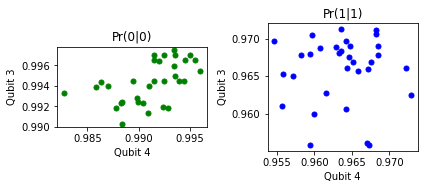

----------------------------------------------------------------------
Qubits (3, 2)
   Name Pearson's r    p-value Spearman's rho    p-value
Pr(0|0)     0.48248  0.0051637        0.57923  0.0005134
Pr(1|1)     0.41159   0.019259         0.3596    0.04323


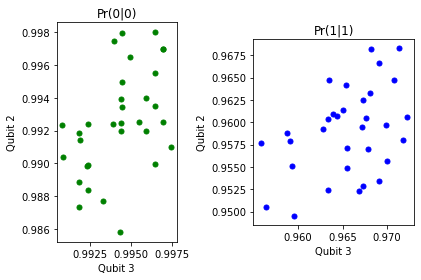

----------------------------------------------------------------------
Qubits (3, 1)
   Name Pearson's r    p-value Spearman's rho    p-value
Pr(0|0)     0.44488   0.010734        0.53767  0.0015054
Pr(1|1)    -0.13825     0.4505       -0.18732    0.30461


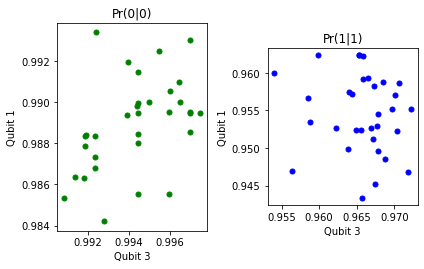

----------------------------------------------------------------------
Qubits (1, 0)
   Name Pearson's r    p-value Spearman's rho    p-value
Pr(0|0)    -0.10046    0.58433         0.0143    0.93808
Pr(1|1)   -0.038165    0.83571       0.042889    0.81571


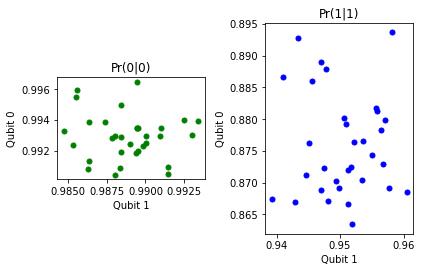

----------------------------------------------------------------------
Qubits (4, 1)
   Name Pearson's r    p-value Spearman's rho    p-value
Pr(0|0)     0.36659   0.039043        0.34186   0.055487
Pr(1|1)     0.04806    0.79394       0.061584    0.73776


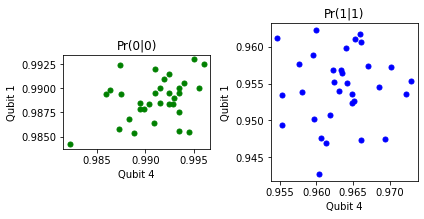

----------------------------------------------------------------------
Qubits (2, 1)
   Name Pearson's r    p-value Spearman's rho    p-value
Pr(0|0)     0.17505    0.33793        0.28283    0.11676
Pr(1|1)     0.10066    0.58358        0.14663    0.42325


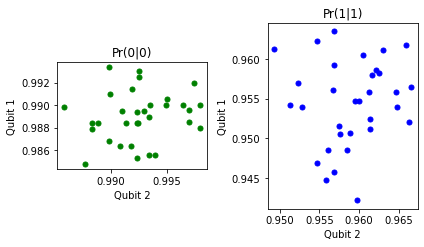

----------------------------------------------------------------------
Qubits (3, 0)
   Name Pearson's r    p-value Spearman's rho    p-value
Pr(0|0)     0.21017    0.24827        0.29237    0.10442
Pr(1|1)   -0.059848     0.7449       -0.13893    0.44826


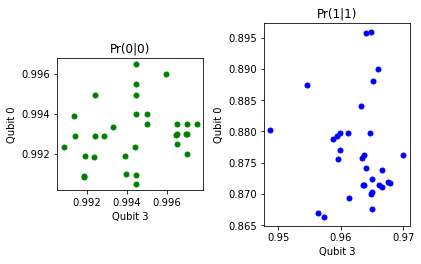

----------------------------------------------------------------------
Qubits (4, 1)
   Name Pearson's r    p-value Spearman's rho    p-value
Pr(0|0)     0.36659   0.039043        0.34186   0.055487
Pr(1|1)     0.04806    0.79394       0.061584    0.73776


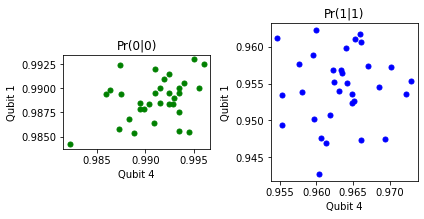

----------------------------------------------------------------------
Qubits (2, 1)
   Name Pearson's r    p-value Spearman's rho    p-value
Pr(0|0)     0.17505    0.33793        0.28283    0.11676
Pr(1|1)     0.10066    0.58358        0.14663    0.42325


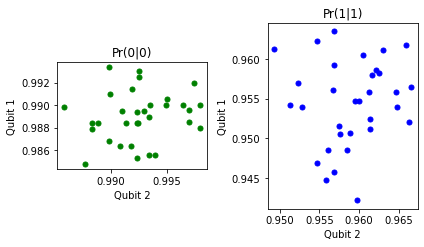

----------------------------------------------------------------------
Qubits (4, 0)
   Name Pearson's r    p-value Spearman's rho    p-value
Pr(0|0)     0.03167    0.86338        0.14096    0.44159
Pr(1|1)   -0.083075    0.65125       -0.12098    0.50954


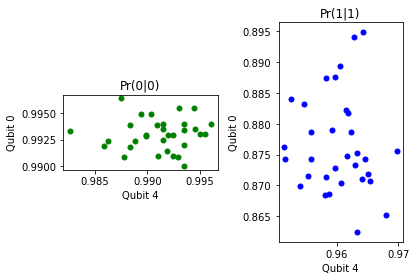

----------------------------------------------------------------------
Qubits (2, 0)
   Name Pearson's r    p-value Spearman's rho    p-value
Pr(0|0)  -0.0060237     0.9739        0.11877    0.51736
Pr(1|1)   -0.056715    0.75784      -0.076246    0.67832


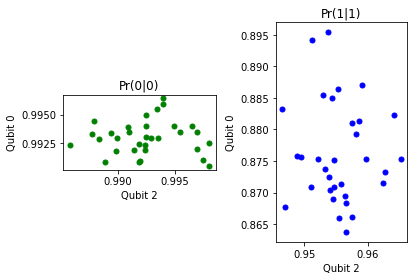

----------------------------------------------------------------------


In [9]:
coupling_maps = [(4,3),(3,2),(3,1),(1,0),(4,1),(2,1),(3,0),(4,1),(2,1),(4,0),(2,0)]
# coupling_maps = [(0,1),(1,2),(1,3),(3,4),(0,4),(2,0),(1,4)]

for interested_qubits in coupling_maps:
    print("Qubits",interested_qubits)
    p0m0,p1m1 = all0_all1_counts(interested_qubits, num_points, num_qubits, file_address)

    r0 = ss.pearsonr(p0m0[0], p0m0[1])
    rank0 = ss.spearmanr(p0m0, axis=1, nan_policy='propagate')
    r1 = ss.pearsonr(p1m1[0], p1m1[1])
    rank1 = ss.spearmanr(p1m1, axis=1, nan_policy='propagate')
    meas = np.array([r0+rank0,r1+rank1])

    format_df = pd.DataFrame(['Pr(0|0)', 'Pr(1|1)'], columns=["Name"])
    format_df = format_df.join(pd.DataFrame(meas, columns=[ "Pearson's r", "p-value", "Spearman's rho", "p-value"]))
    print(format_df.to_string(formatters=["{:>5}".format,
                                          "{:>10.5g}".format,
                                          "{:>10.5g}".format,
                                          "{:>10.5g}".format,
                                          "{:>10.5g}".format],index=False))
    
    # Plots
    fig = plt.figure()
    
    ax1 = fig.add_subplot(1,2,1, adjustable='box', aspect=1)
    ax2 = fig.add_subplot(1,2,2, adjustable='box', aspect=1)
    ax1.plot(p0m0[0], p0m0[1], 'go',markersize=5)
    ax1.set_xlabel("Qubit {:d}".format(interested_qubits[0]))
    ax1.set_ylabel("Qubit {:d}".format(interested_qubits[1]))
    ax1.set_title("Pr(0|0)")
    
    ax2.plot(p1m1[0], p1m1[1], 'bo',markersize=5)
    ax2.set_xlabel("Qubit {:d}".format(interested_qubits[0]))
    ax2.set_ylabel("Qubit {:d}".format(interested_qubits[1]))
    ax2.set_title("Pr(1|1)")
    plt.tight_layout()
    plt.show()
    print("-"*70)